In [2]:
:dep ndarray = { version = "0.15.6"}
:dep plotters = { version = "0.3.5", default_features = false, features = ["evcxr", "all_series"] }
:dep graphviz-rust = { version = "0.9.0" }

:dep base64 = {version = "0.22.0"}

use ndarray::{Array, Zip};
use plotters::prelude::*;

use graphviz_rust::dot_generator::*;
use graphviz_rust::dot_structures::*;
use graphviz_rust::{
    exec_dot,
    cmd::Format,
    printer::{PrinterContext, DotPrinter},
};
use base64::prelude::*;

In [ ]:
fn f(x: f64) -> f64 {
    3.0*x.powi(2) - 4.0*x + 5.0
}

In [ ]:
f(3.0)

In [ ]:
let xs = Array::range(-5., 5., 0.25);

In [ ]:
let ys = xs.map(|&x| f(x));

In [ ]:
evcxr_figure((680, 480), |root| {
    let mut chart = ChartBuilder::on(&root)
        .margin(30)
        .x_label_area_size(30)
        .y_label_area_size(30)
        .build_cartesian_2d(-5.0..5.0, 0.0..100.0)?;
    chart.configure_mesh().draw()?;
    chart.draw_series(LineSeries::new(xs.map(|&x| (x, f(x))), &BLACK))?;
    chart.configure_series_labels()
        .border_style(&BLACK).draw()?;
    root.present()?;
    Ok(())
})

In [ ]:
let h = 0.00000001;
let x = 2.0/3.0;
(f(x+h) - f(x)) / h

In [ ]:
let a = 2.0;
let b = -3.0;
let c = 10.0;
let d = a*b +c;
d

In [ ]:
let h = 0.0001;

// Inputs
let mut a = 2.0;
let mut b = -3.0;
let mut c = 10.0;

let d1 = a*b + c;
c += h;
let d2 = a*b + c;

println!("d1 {d1}");
println!("d2 {d2}");
// Normalized by h to get the slope
println!("slope {}", (d2 - d1)/h);

In [ ]:
let mut g = graph!(id!("id");
    node!("nod"),
    edge!(node_id!("a1") => node_id!(esc "a2"))
);

In [3]:
pub fn print_evcxr(graph: Graph) {
    let dot = graph.print(&mut PrinterContext::default());
    let format = Format::Svg;
    println!("EVCXR_BEGIN_CONTENT image/png");
    let graph_svg = exec_dot(dot, vec![graphviz_rust::cmd::CommandArg::Custom("-Tpng".to_string())]).expect("Failed");
    println!("{}", BASE64_STANDARD.encode(graph_svg));
    println!("EVCXR_END_CONTENT");
}

In [4]:
print_evcxr(g);

Error: cannot find value `g` in this scope

In [8]:
fn draw_dot_local<'a, T>(root: &'a Value<T>)
where T: std::fmt::Debug + std::cmp::PartialEq + std::ops::Add + std::ops::Mul + Clone + Copy + Zero + One + Default,
{
    // Create the graph left to write
    let mut graph = graph!(id!("oxgrad"); attr!("rankdir", "LR"));
    let (nodes, edges) = oxgrad::trace(root);

    for n in nodes.iter() {
        // Add a node for every value in the graph
        let n_id = format!("{}", n.id);

        let _dot_node = graph.add_stmt(
            node!(&n_id;
                attr!("shape", "record"),
                attr!("label", esc &format!("{} | data {:.4?} | grad {:.4?}", n.label, n.data, n.grad.get()))
            ).into());
        if let Some(op) = &n.op {
            let op_id = format!("{} + {}", n.id, n.op_id());
            // If this current value is the result of an operation, create a node for the operation
            graph.add_stmt(node!(esc op_id; attr!("label", esc op.to_string())).into());
            // And connect the 2 nodes
            graph.add_stmt(edge!(node_id!(esc op_id) => node_id!(n_id)).into());
        }
    }

    // For each of the nodes in the found edges
    for (n1, n2) in edges.iter() {
        let n1_id = format!("{}", n1.id);
        let n2_op_id = format!("{} + {}", n2.id, n2.op_id());
        // Connect n1 to the operation node of n2
        graph.add_stmt(edge!(node_id!(n1_id) => node_id!(esc n2_op_id)).into());
    }
    print_evcxr(graph);
}

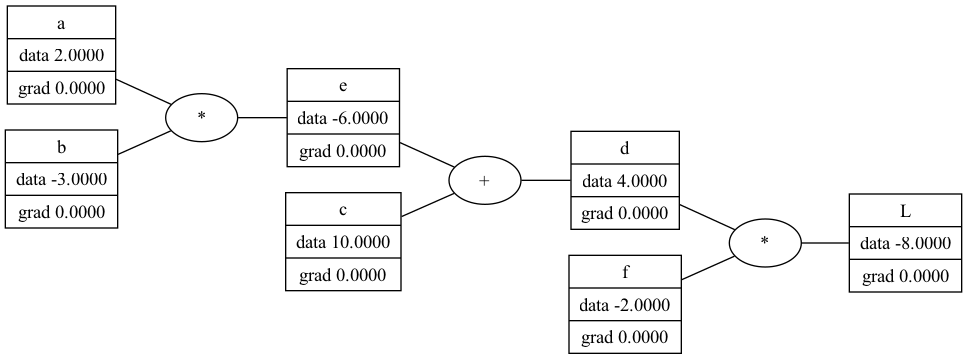

In [9]:
draw_dot_local(&L);

In [14]:
:dep oxgrad = { version = "0.1.0", path = "../../oxgrad"}
use oxgrad::{Value, Tanh, Zero, One};

let a: Value<f64> = Value::new(2.0, "a");
let b: Value<f64> = Value::new(-3.0, "b");
let c: Value<f64> = Value::new(10.0, "c");
let mut e: Value<f64> = a*b;
e.label = "e".to_string();
let mut d: Value<f64> = e+c;
d.label = "d".to_string();
let mut f: Value<f64> = Value::new(-2.0, "f");
let mut L: Value<f64> = d*f;
L.label = "L".to_string();


Error: 1 positional argument in format string, but no arguments were given

Error: mismatched types

Error: mismatched types

In [15]:
// Unfortunately, we have to set the gradients before performing the operation
// on the value, since the current design consumes by value, which is more correct.
// Once something is used to produce a result, you should not be able to modify it further
// outside the scope it produces the result in. At least this is my take.
// Again derivative: As x tends to 0
// f(x+h) - f(x) / h

// Inputs x1, x2
let mut x1 = Value::new(2.0, "x1");
let mut x2 = Value::new(0.0, "x2");
// Weights w1, w2
let mut w1 = Value::new(-3.0, "w1");
let mut w2 = Value::new(1.0, "w2");

// Bias of neuron
let mut b = Value::new(6.8813735870195432, "b");

// x1*w1 + x2*w2 + b
let mut x1w1 = x1*w1;
x1w1.label = "x1w1".to_string();

let mut x2w2 = x2*w2;
x2w2.label = "x2w2".to_string();

let mut x1w1_plus_x2w2 = x1w1 + x2w2;
x1w1_plus_x2w2.label = "x1*w1 + x2*w2".to_string();
let mut n = x1w1_plus_x2w2 + b;
n.label = "n".to_string();
// do/dn = 1 - o**2
let mut o: Value<f64> = n.tanh();
o.label = "o".to_string();

Error: 1 positional argument in format string, but no arguments were given

Error: mismatched types

Error: mismatched types

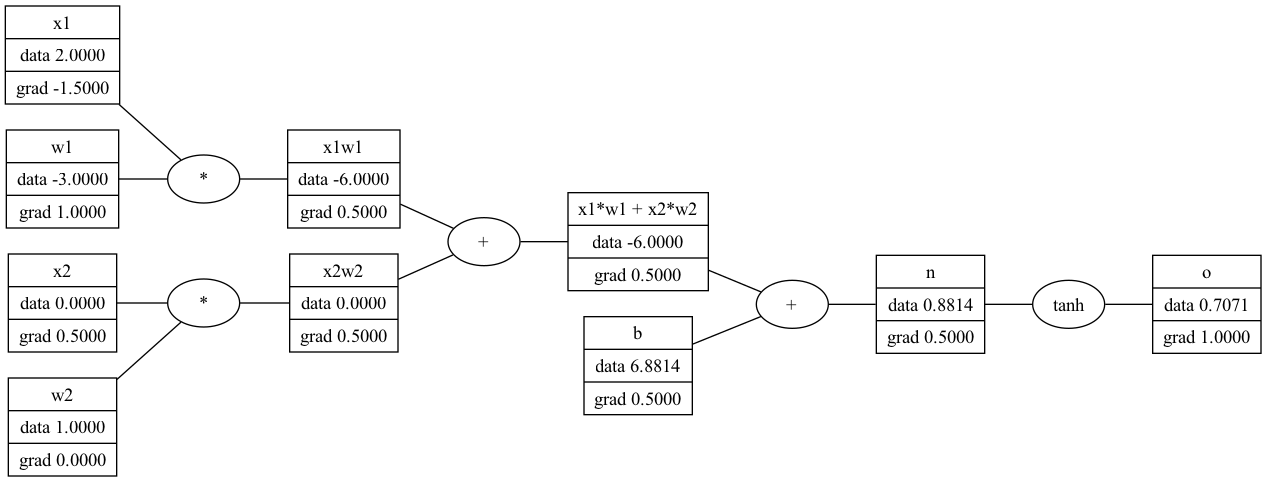

In [12]:
o.backward();
draw_dot_local(&o);

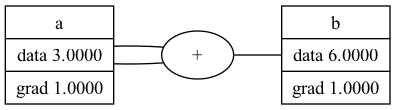

In [13]:
let mut a = Value::new(3.0,  "a");
let mut b: Value<f64>= a.clone() + a;
b.label = "b".to_string();
b.backward();
draw_dot_local(&b);

In [ ]:
let mut a = Value::new(-2.0,  "a");
let mut b = Value::new(3.0,  "b");
let mut d: Value<f64> = a.clone() * b.clone(); d.label = "d".to_string();
let mut e = a + b; e.label = "e".to_string();
let mut f: Value<f64> = d * e; f.label = "f".to_string();

f.backward();
draw_dot_local(&f);